## Exercises - Chapter 09

for the exercises where i referenced the solutions page, i added comments to help display understanding

In [37]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


red_wine = pd.read_csv('./data/winequality-red.csv')
white_wine = pd.read_csv('./data/winequality-white.csv', sep=';')
print(white_wine.shape,
      red_wine.shape)

(4898, 12) (1599, 12)


#### Exercise 01

1. Build a clustering model to distinguish between red and white wine by their 
chemical properties:\
a) Combine the red and white wine datasets (data/winequality-red.csv
and data/winequality-white.csv, respectively) and add a column for the 
kind of wine (red or white).\
b) Perform some initial EDA.\
c) Build and fit a pipeline that scales the data and then uses k-means clustering to 
make two clusters. Be sure not to use the quality column.\
d) Use the Fowlkes-Mallows Index (the fowlkes_mallows_score() function 
is in sklearn.metrics) to evaluate how well k-means is able to make the 
distinction between red and white wine.\
e) Find the center of each cluster

<AxesSubplot:title={'center':'White Wine Quality Scores'}, xlabel='count of wines', ylabel='quality score'>

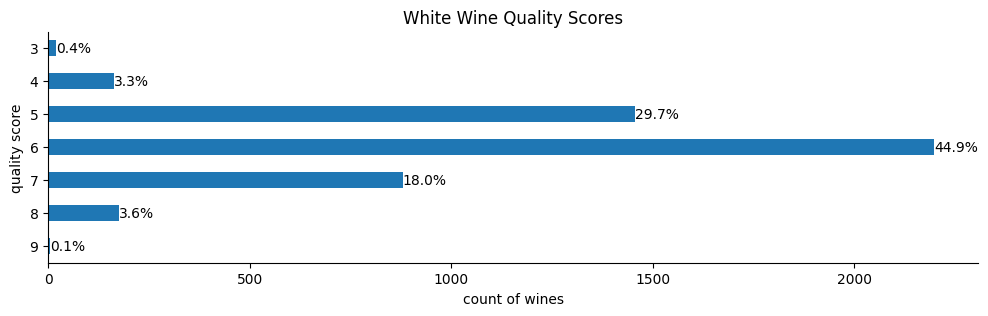

In [15]:
def plot_quality_scores(df, kind):
    # count # of unique wine scores and sort on a bar chart
    ax = df.quality.value_counts().sort_index().plot.barh(
        title=f'{kind.title()} Wine Quality Scores', figsize=(12, 3)
    )
    
    # have lowest at top, highest at bottom
    ax.axes.invert_yaxis()
    
    # label each bar with % of occurance
    for bar in ax.patches:
        ax.text(
            bar.get_width(), 
            bar.get_y() + bar.get_height()/2, 
            f'{bar.get_width()/df.shape[0]:.1%}',
            verticalalignment='center'
        )
    
    # label axis
    plt.xlabel('count of wines')
    plt.ylabel('quality score')

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    return ax

plot_quality_scores(white_wine, 'white')

<AxesSubplot:title={'center':'Red Wine Quality Scores'}, xlabel='count of wines', ylabel='quality score'>

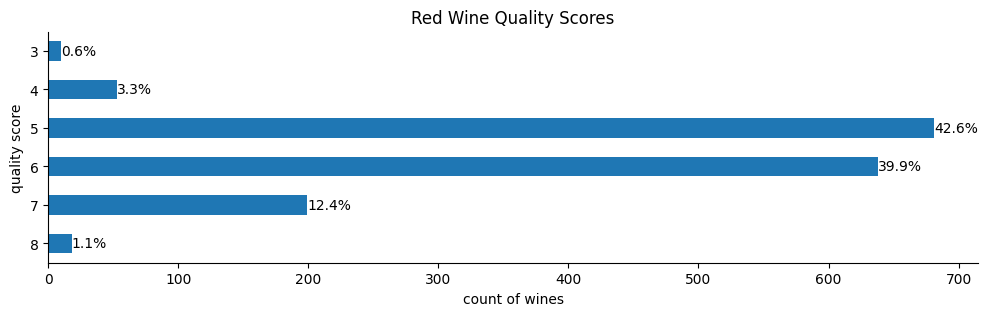

In [17]:
plot_quality_scores(red_wine, 'red')

In [20]:
# combine the data
wine = pd.concat([white_wine.assign(kind='white'), red_wine.assign(kind='red')])
wine.sample(5, random_state=10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,kind
848,6.4,0.64,0.21,1.8,0.081,14.0,31.0,0.99689,3.59,0.66,9.8,5,red
2529,6.6,0.42,0.13,12.8,0.044,26.0,158.0,0.99772,3.24,0.47,9.0,5,white
131,5.6,0.50,0.09,2.3,0.049,17.0,99.0,0.99370,3.63,0.63,13.0,5,red
244,15.0,0.21,0.44,2.2,0.075,10.0,24.0,1.00005,3.07,0.84,9.2,7,red
1551,6.6,0.19,0.99,1.2,0.122,45.0,129.0,0.99360,3.09,0.31,8.7,6,white


In [21]:
wine.kind.value_counts()

white    4898
red      1599
Name: kind, dtype: int64

<AxesSubplot:title={'center':'Overall Wine Quality Scores'}, xlabel='count of wines', ylabel='quality score'>

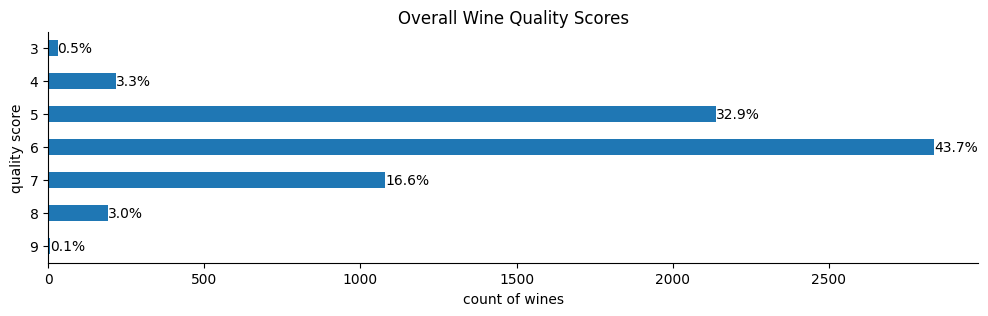

In [24]:
# overall scores
plot_quality_scores(wine, 'overall')

In [31]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Clustering to Separate Red and White Wines

# define x and y 
y = wine.kind
X = wine.drop(columns=['quality', 'kind'])

# split data into train and test sets
# scale y to have fair representation of wine kinds
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y
)

# this was done in the chapter where data is scaled to zero mean 
# then data is split into 2 clusters 
# train pipeline on x_train
kmeans_pipeline = Pipeline([
    ('scale', StandardScaler()), 
    ('kmeans', KMeans(n_clusters=2, random_state=0))
]).fit(X_train)

In [32]:
# Measure the agreement between predicted wine type and actual
pd.Series(kmeans_pipeline.predict(X_test)).value_counts()

0    1211
1     414
dtype: int64

In [30]:
y_test.value_counts()

white    1225
red       400
Name: kind, dtype: int64

#### Fowlkes Mallows Index
Values are in the range [0, 1] where 1 is perfect agreement:
$$ FMI = \frac{TP}{\sqrt{(TP + FP)\times(TP + FN)}} $$
where
- TP = points that are in the same cluster in the true labels are predicted to be in the same cluster
- FP = points that are in the same cluster in the true labels but are not predicted to be in the same cluster
- FN = points that are not in the same cluster in the true labels but are predicted to be in the same cluster

In [36]:
from sklearn.metrics import fowlkes_mallows_score
# we need to make y_test binary, but which label red becomes doesn't matter for the result
fowlkes_mallows_score(np.where(y_test == 'red', 0, 1), kmeans_pipeline.predict(X_test))
# score is scaled 0 to 1, closer to 1 means more similar clusters

0.9824673716471775

In [35]:
# Finding the Centroids
# convert to a df with columns correspond to X_train features then transpose
pd.DataFrame(
    kmeans_pipeline.named_steps['kmeans'].cluster_centers_,
    columns=X_train.columns
).T

,0,1
fixed acidity,-0.275759,0.811214
volatile acidity,-0.400013,1.176737
citric acid,0.124803,-0.367138
residual sugar,0.213872,-0.629158
chlorides,-0.319649,0.940326
free sulfur dioxide,0.286878,-0.843924
total sulfur dioxide,0.404915,-1.191159
density,-0.224677,0.660942
pH,-0.194171,0.571201
sulphates,-0.288408,0.848424


#### Exercise 02

2. Predict star temperature:\
a) Using the data/stars.csv file, perform some initial EDA and then build a linear regression model of all the numeric columns to predict the temperature of the star.\
b) Train the model on 75% of the initial data.\
c) Calculate the R2 and RMSE of the model.\
d) Find the coefficients for each regressor and the intercept of the linear regression equation.\
e) Visualize the residuals using the plot_residuals() function from the ml_utils.regression module.\

In [42]:
stars = pd.read_csv('./data/stars.csv')
stars.describe()

,magK,magB,metallicity,magH,mass,magV,radius,magJ,temperature,planets
count,2641.000000,1124.000000,2982.000000,2610.000000,3922.000000,2001.000000,3439.000000,2621.000000,3505.000000,4110.000000
mean,10.176295,11.000875,0.014878,10.286071,0.944221,11.032630,1.839017,10.671899,5449.977228,1.251338
std,3.083324,3.064289,0.189856,3.091399,0.580813,3.219532,14.153331,3.077200,1629.202602,0.829219
min,-1.490000,0.720000,-2.090000,-1.380000,0.010000,0.010000,0.000014,-1.150000,58.370000,0.000000
25%,7.721000,8.649000,-0.067750,7.817750,0.764750,8.380000,0.790000,8.324000,4975.000000,1.000000
50%,11.015000,11.218500,0.020000,11.112500,0.950000,11.484000,0.979000,11.485000,5595.000000,1.000000
75%,12.627000,13.270500,0.120000,12.744750,1.100000,13.220000,1.273000,13.150000,5940.000000,1.000000
max,19.160000,19.860000,0.560000,20.800000,21.000000,24.440000,800.000000,21.600000,57000.000000,9.000000


In [46]:
stars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4110 entries, 0 to 4109
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   magK          2641 non-null   float64
 1   magB          1124 non-null   float64
 2   metallicity   2982 non-null   float64
 3   magH          2610 non-null   float64
 4   name          4110 non-null   object 
 5   mass          3922 non-null   float64
 6   magV          2001 non-null   float64
 7   spectraltype  1550 non-null   object 
 8   radius        3439 non-null   float64
 9   magJ          2621 non-null   float64
 10  temperature   3505 non-null   float64
 11  planets       4110 non-null   float64
dtypes: float64(10), object(2)
memory usage: 385.4+ KB


In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

data = stars[['metallicity', 'temperature', 'magJ', 'radius', 'magB', 'magV', 'magK', 'mass', 'planets']].dropna()
y = data.pop('temperature')
X = data

# test_size = train model on 75% of initial data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

# create the linear regression model
lm = LinearRegression().fit(X_train, y_train)
# calculate the R-squared
lm.score(X_test, y_test)

0.7796283481508328

In [54]:
from sklearn.metrics import mean_squared_error
# calculate the RMSE (root mean squared error)
np.sqrt(mean_squared_error(y_test, lm.predict(X_test)))

429.7625802032138

In [55]:
# find coef for each regressor
[(coef, feature) for coef, feature in zip(lm.coef_, X_train.columns)]

[(-70.91571547833348, 'metallicity'),
 (-1483.293767746354, 'magJ'),
 (0.552178216452603, 'radius'),
 (-286.76712140347377, 'magB'),
 (-145.78415500402517, 'magV'),
 (1944.060261632505, 'magK'),
 (244.19275753392446, 'mass'),
 (-19.423582748116594, 'planets')]

In [56]:
# calculate the intercept of linear regression equation
# intercept is point where the regression line crosses the y-axis
lm.intercept_

6777.244850448117

array([<AxesSubplot:xlabel='Observation', ylabel='Residual'>,
       <AxesSubplot:xlabel='Residual', ylabel='Density'>], dtype=object)

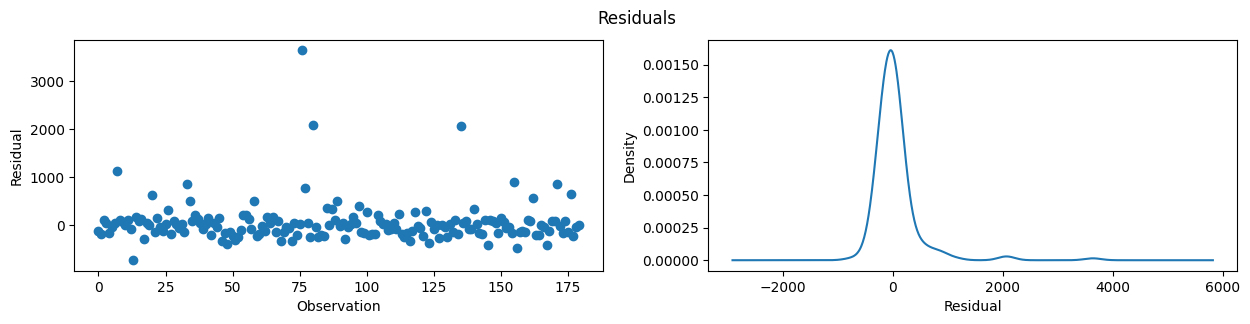

In [57]:
from ml_utils.regression import plot_residuals
# predict target values of x_test
pred = lm.predict(X_test)
# plot residuals of the regression model
# residuals is the differences between observed and predicted values
plot_residuals(y_test, pred)

#### Exercise 03

3. Classify planets that have shorter years than Earth:\
a) Using the data/planets.csv file, build a logistic regression model with the eccentricity, semimajoraxis, and mass columns as regressors. You will need to make a new column to use for the y (year shorter than Earth).\
b) Find the accuracy score.\
c) Use the classification_report() function from scikit-learn to see the precision, recall, and F1 score for each class.\
d) With the plot_roc() function from the ml_utils.classificationmodule, plot the ROC curve.\
e) Create a confusion matrix using the confusion_matrix_visual() function from the ml_utils.classification module.

In [59]:
planets = pd.read_csv('./data/planets.csv')
planets.describe()

,periastrontime,discoveryyear,eccentricity,semimajoraxis,period,mass,periastron
count,2.020000e+02,5178.000000,2015.000000,2600.000000,4.909000e+03,2552.000000,931.000000
mean,2.541622e+06,2015.249517,0.286252,7.883031,2.189080e+03,2.292662,133.445156
std,1.570355e+06,5.971855,6.237088,159.148610,1.149292e+05,7.157556,119.509784
min,2.452942e+05,1781.000000,-0.129287,0.004420,6.511500e-02,0.000008,-233.000000
25%,2.452554e+06,2014.000000,0.000000,0.050697,4.444480e+00,0.030950,46.340794
50%,2.454185e+06,2016.000000,0.080000,0.118390,1.184900e+01,0.520000,121.000000
75%,2.455517e+06,2018.000000,0.210000,1.050000,4.252159e+01,2.090000,223.548513
max,2.453248e+07,2023.000000,280.000000,6471.000000,8.040000e+06,263.000000,791.000000


<AxesSubplot:>

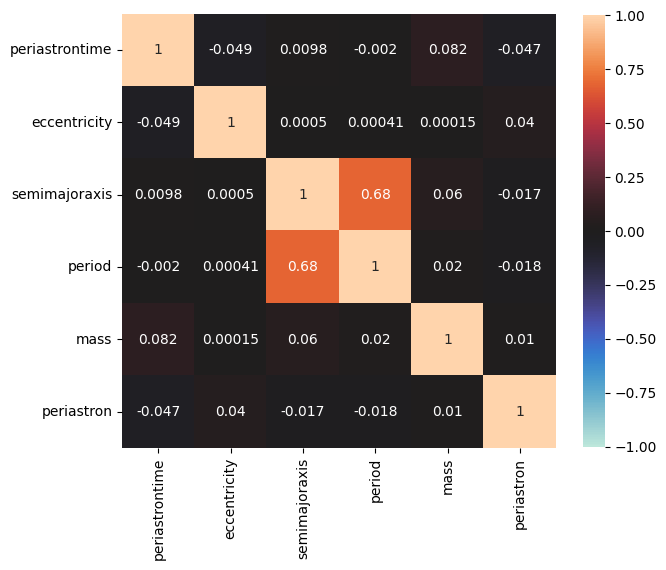

In [60]:
fig = plt.figure(figsize=(7, 7))
sns.heatmap(
    planets.drop(columns='discoveryyear').corr(), 
    center=0, vmin=-1, vmax=1, square=True, annot=True,
    cbar_kws={'shrink': 0.8}
)

In [62]:
# create column for the y, year shorter than earth
planets['shorter_year_than_earth'] = planets.period < planets.query('name == "Earth"').period.iat[0]
planets.shorter_year_than_earth.value_counts()

True     4346
False     841
Name: shorter_year_than_earth, dtype: int64

In [64]:
# create the logisitic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

data = planets[['shorter_year_than_earth', 'semimajoraxis', 'mass', 'eccentricity']].dropna()
y = data.pop('shorter_year_than_earth')
X = data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y
)

lm = LogisticRegression(random_state=0).fit(X_train, y_train)

print(f"Accuracy: {lm.score(X_test, y_test)}")

Accuracy: 0.9642857142857143


In [67]:
from sklearn.metrics import classification_report
# create a classification report
preds = lm.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.97      0.91      0.94       130
        True       0.96      0.99      0.98       318

    accuracy                           0.96       448
   macro avg       0.97      0.95      0.96       448
weighted avg       0.96      0.96      0.96       448



<AxesSubplot:title={'center':'ROC curve'}, xlabel='False Positive Rate (FPR)', ylabel='True Positive Rate (TPR)'>

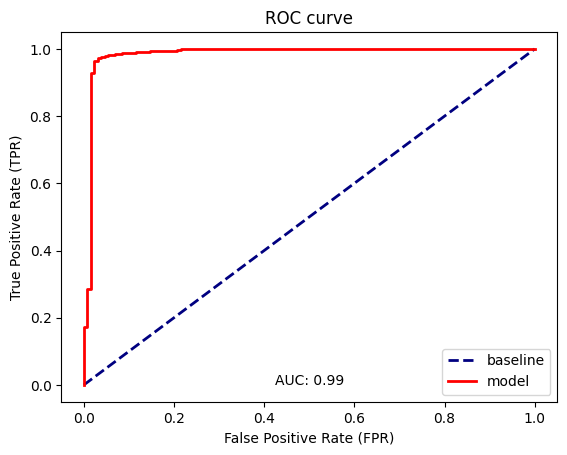

In [70]:
from ml_utils.classification import plot_roc

# ROC curve is true positive rate against false positive rate
plot_roc(y_test, lm.predict_proba(X_test)[:,1])

In [73]:
from sklearn.metrics import roc_auc_score

probabilities = lm.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, probabilities)
# AUC is area under curve
# perfect classifer is 1.0, random classifer is 0.5 (higher is better)

0.9851233671988389

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Actual', ylabel='Model Prediction'>

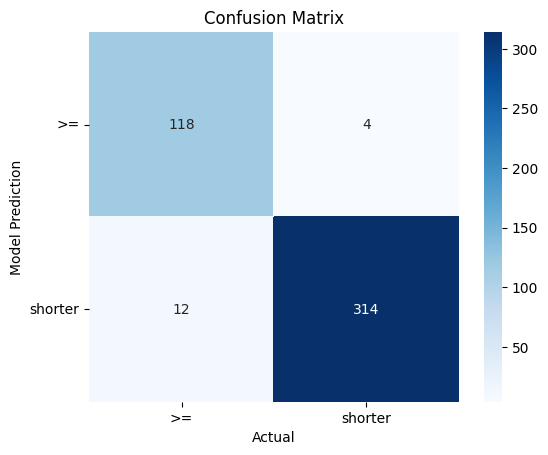

In [79]:
from ml_utils.classification import confusion_matrix_visual
# confusion matrix of actual vs predicted 
confusion_matrix_visual(y_test, preds, ['>=', 'shorter'])
# show true positives, false positives, true negatives, and false negatives between inputs

#### Exercise 04

4. Multiclass classification of white wine quality:\
a) Using the data/winequality-white.csv file, perform some initial EDA on the white wine data. Be sure to look at how many wines had a given quality score.\
b) Build a pipeline to standardize the data and fit a multiclass logistic regression model. Pass multi_class='multinomial' and max_iter=1000 to the LogisticRegression constructor.\
c) Look at the classification report for your model.\
d) Create a confusion matrix using the confusion_matrix_visual() function from the ml_utils.classification module. This will work as is for multiclass classification problems.\
e) Extend the plot_roc() function to work for multiple class labels. To do so, you will need to create a ROC curve for each class label (which are quality scores here), where a true positive is correctly predicting that quality score and a false  positive is predicting any other quality score. Note that ml_utils has a function for this, but try to build your own implementation.\
f) Extend the plot_pr_curve() function to work for multiple class labels by following a similar method to part e). However, give each class its own subplot. Note that ml_utils has a function for this, but try to build your own implementation.\

In [77]:
white_wine = pd.read_csv('./data/winequality-white.csv', sep=';')
white_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [78]:
white_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


Below function was originally created in Exercise 01

<AxesSubplot:title={'center':'White Wine Quality Scores'}, xlabel='count of wines', ylabel='quality score'>

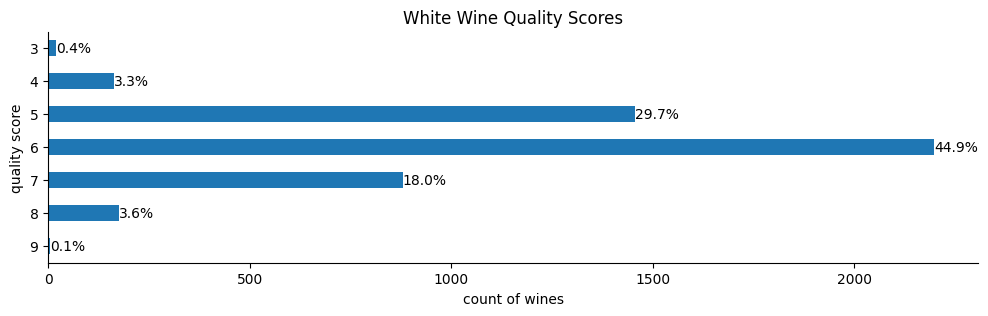

In [80]:
def plot_quality_scores(df, kind):
    ax = df.quality.value_counts().sort_index().plot.barh(
        title=f'{kind.title()} Wine Quality Scores', figsize=(12, 3)
    )
    ax.axes.invert_yaxis()
    for bar in ax.patches:
        ax.text(
            bar.get_width(), 
            bar.get_y() + bar.get_height()/2, 
            f'{bar.get_width()/df.shape[0]:.1%}',
            verticalalignment='center'
        )
    plt.xlabel('count of wines')
    plt.ylabel('quality score')

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    return ax

plot_quality_scores(white_wine, 'white')

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

y = white_wine.quality
X = white_wine.drop(columns=['quality'])

# 75/25 split of train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y
)

# Exercise 01 created a Kmeans pipeline, this time its for multiclass logistic regression
lm_pipeline = Pipeline([
    ('scale', StandardScaler()), 
    ('lm', LogisticRegression(multi_class='multinomial', random_state=0, max_iter=1000))
]).fit(X_train, y_train)

In [83]:
# get the predictions
preds = lm_pipeline.predict(X_test)

In [90]:
# %%capture --no-stdout
# they used the above option to suppress a UndefinedMetricWarning, but doing what the warning suggests is better
# zero_division=0 provides the same results as what they get
# warning happens because some labels in data has no workable samples (assume 8 and 9 precision)
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

           3       1.00      0.20      0.33         5
           4       0.88      0.17      0.29        41
           5       0.59      0.54      0.56       364
           6       0.53      0.76      0.62       550
           7       0.54      0.21      0.31       220
           8       0.00      0.00      0.00        44
           9       0.00      0.00      0.00         1

    accuracy                           0.55      1225
   macro avg       0.50      0.27      0.30      1225
weighted avg       0.54      0.55      0.51      1225



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Actual', ylabel='Model Prediction'>

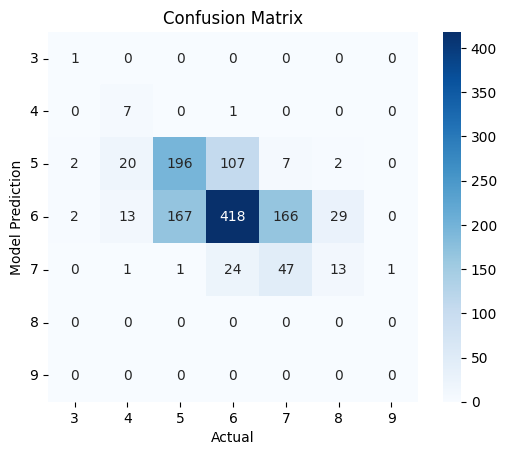

In [92]:
from ml_utils.classification import confusion_matrix_visual
# multiclass confusion matrix
confusion_matrix_visual(y_test, preds, np.sort(y_test.unique()))

In [97]:
from ml_utils.classification import plot_multiclass_roc
# Extend the `plot_roc()` function to multiclass classification problems
plot_multiclass_roc??
# appending "??" at the end ofa function gives info about the function

<AxesSubplot:title={'center':'Multiclass ROC curve'}, xlabel='False Positive Rate (FPR)', ylabel='True Positive Rate (TPR)'>

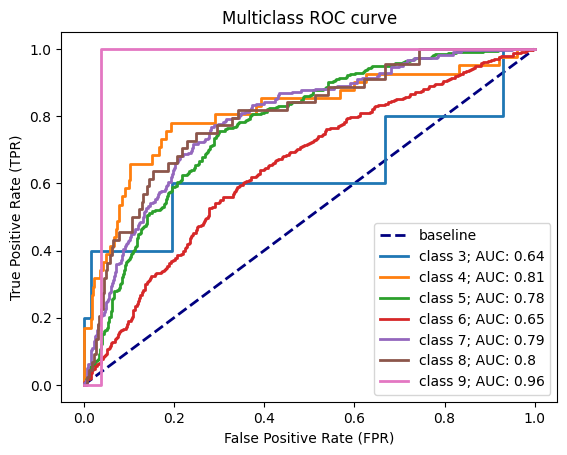

In [98]:
plot_multiclass_roc(y_test, lm_pipeline.predict_proba(X_test))

In [99]:
from ml_utils.classification import plot_multiclass_pr_curve
plot_multiclass_pr_curve??

array([<AxesSubplot:title={'center':'Precision-recall curve: class 3'}, xlabel='Recall', ylabel='Precision'>,
       <AxesSubplot:title={'center':'Precision-recall curve: class 4'}, xlabel='Recall', ylabel='Precision'>,
       <AxesSubplot:title={'center':'Precision-recall curve: class 5'}, xlabel='Recall', ylabel='Precision'>,
       <AxesSubplot:title={'center':'Precision-recall curve: class 6'}, xlabel='Recall', ylabel='Precision'>,
       <AxesSubplot:title={'center':'Precision-recall curve: class 7'}, xlabel='Recall', ylabel='Precision'>,
       <AxesSubplot:title={'center':'Precision-recall curve: class 8'}, xlabel='Recall', ylabel='Precision'>,
       <AxesSubplot:title={'center':'Precision-recall curve: class 9'}, xlabel='Recall', ylabel='Precision'>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

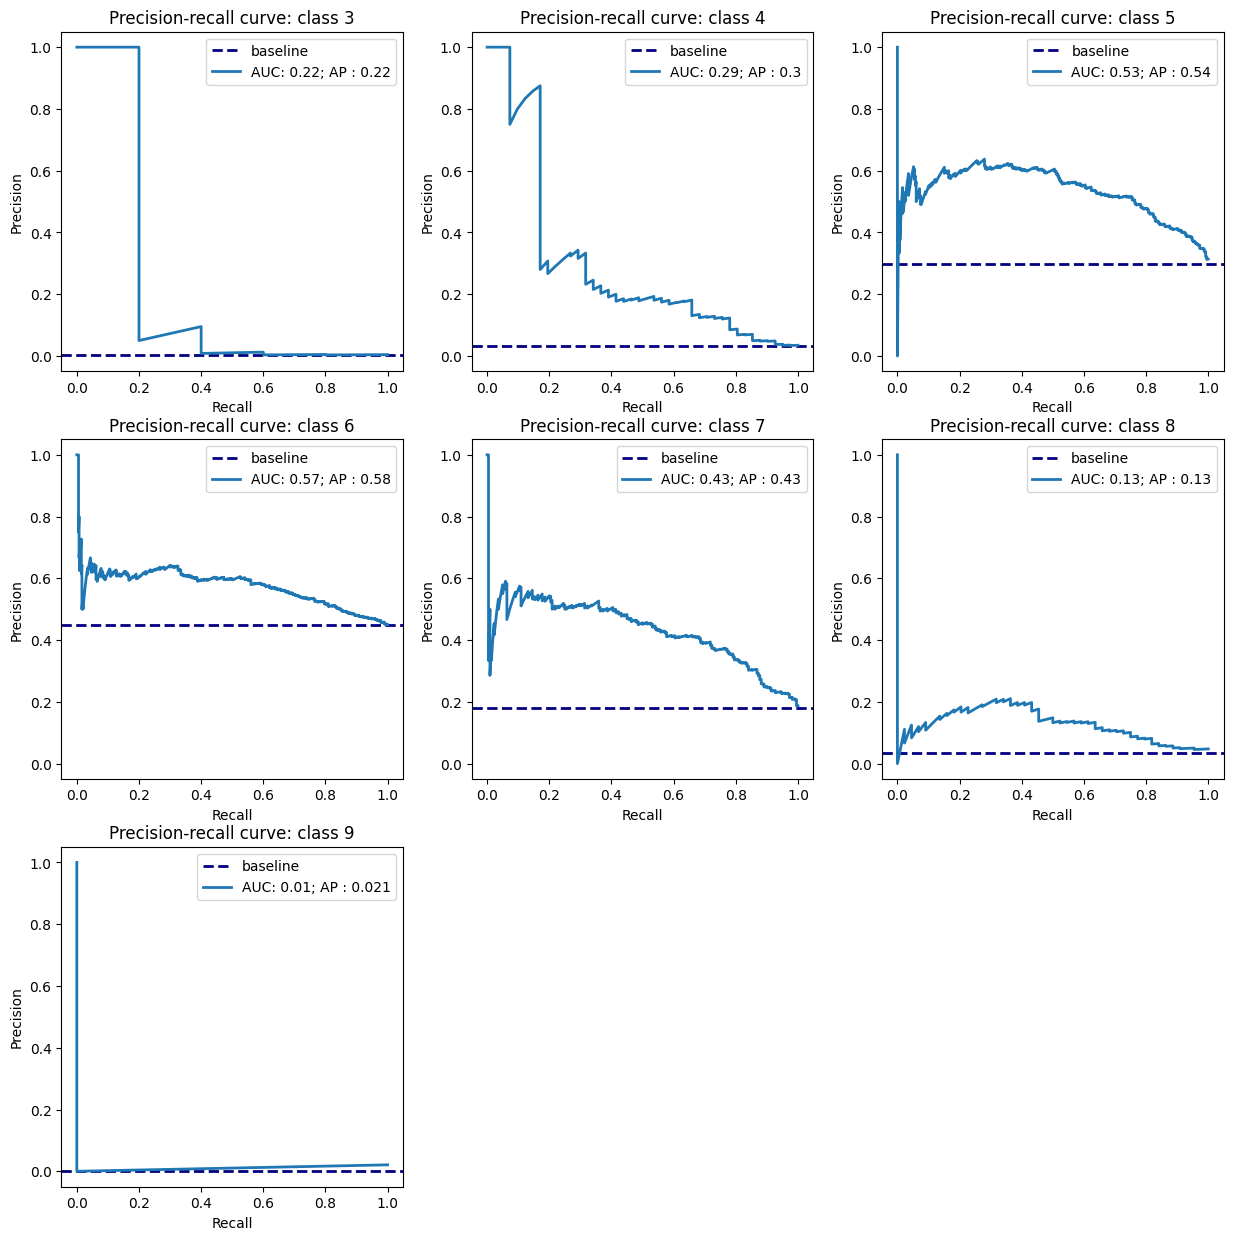

In [100]:
plot_multiclass_pr_curve(y_test, lm_pipeline.predict_proba(X_test))

#### Exercise 05

5. We have seen how easy the scikit-learn API is to navigate, making it a cinch to change which algorithm we are using for our model. Rebuild the red wine quality model that we created in this chapter using an SVM instead of logistic regression. We haven't discussed this model, but you should still be able to use it in scikit-learn. Check out the link in the Further reading section to learn more about the algorithm. Some guidance for this exercise is as follows:\
a) You will need to use the SVC (support vector classifier) class from scikit-learn, which can be found at: \
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html \
b) Use C=5 as an argument to the SVC constructor.\
c) Pass probability=True to the SVC constructor to be able to use the predict_proba() method.\
d) Build a pipeline first using the StandardScaler class and then the SVC class.\
e) Be sure to look at the classification report, precision-recall curve, and confusion matrix for the model.

In [101]:
red_wine = pd.read_csv('./data/winequality-red.csv')
red_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [102]:
red_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Reusing the same function used a few times earlier

<AxesSubplot:title={'center':'Red Wine Quality Scores'}, xlabel='count of wines', ylabel='quality score'>

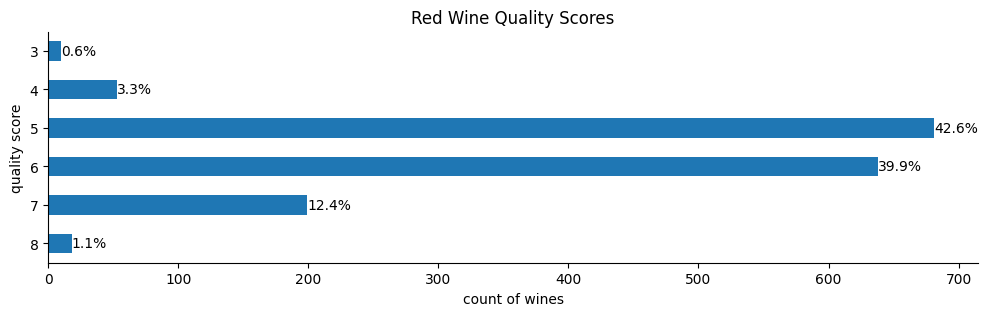

In [103]:
def plot_quality_scores(df, kind):
    ax = df.quality.value_counts().sort_index().plot.barh(
        title=f'{kind.title()} Wine Quality Scores', figsize=(12, 3)
    )
    ax.axes.invert_yaxis()
    for bar in ax.patches:
        ax.text(
            bar.get_width(), 
            bar.get_y() + bar.get_height()/2, 
            f'{bar.get_width()/df.shape[0]:.1%}',
            verticalalignment='center'
        )
    plt.xlabel('count of wines')
    plt.ylabel('quality score')

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    return ax

plot_quality_scores(red_wine, 'red')

In [104]:
# make a column for high quality
red_wine['high_quality'] = pd.cut(red_wine.quality, bins=[0, 6, 10], labels=[0, 1])
red_wine.high_quality.value_counts(normalize=True)

0    0.86429
1    0.13571
Name: high_quality, dtype: float64

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# separate target (high_quality) from set and drop quality column
y = red_wine.pop('high_quality')
X = red_wine.drop(columns=['quality'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=0, stratify=y
)

# create the pipeline
# fit it
pipeline = Pipeline([
    # standardize the data
    ('scale', StandardScaler()), 
    # use SVM. 
    # C=5 is cost parameter. higher = higher training accuracy, risk overfitting
    ('svm', SVC(C=5, random_state=0, probability=True))
]).fit(X_train, y_train)

In [106]:
quality_preds = pipeline.predict(X_test)
print(classification_report(y_test, quality_preds))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       138
           1       0.56      0.45      0.50        22

    accuracy                           0.88       160
   macro avg       0.74      0.70      0.71       160
weighted avg       0.87      0.88      0.87       160



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Actual', ylabel='Model Prediction'>

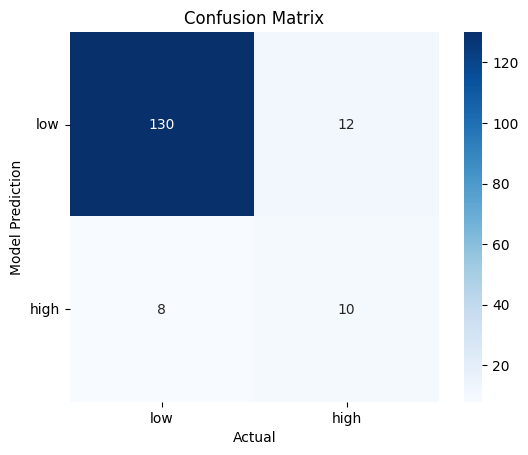

In [107]:
confusion_matrix_visual(y_test, quality_preds, ['low', 'high'])

In [113]:
from ml_utils.classification import plot_pr_curve

plot_pr_curve??

<AxesSubplot:title={'center':'Precision-recall curve\nAP: 0.48 | AUC: 0.45'}, xlabel='Recall', ylabel='Precision'>

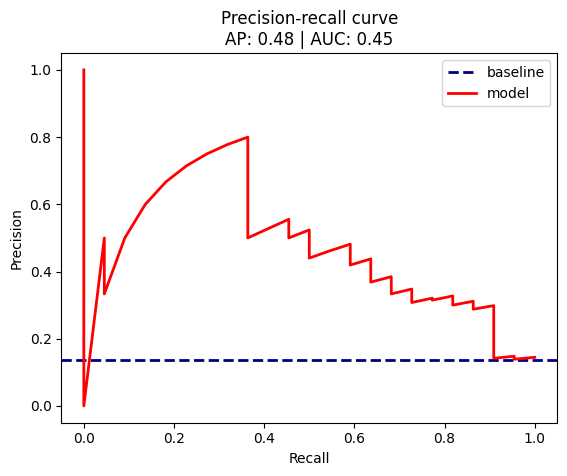

In [115]:
""" Plot precision-recall curve to evaluate classification.

    Parameters:
        - y_test: The true values for y
        - preds: The predicted values for y as probabilities
        - positive_class: The label for the positive class in the data
        - ax: The matplotlib `Axes` object to plot on

    Returns:
        A matplotlib `Axes` object."""

plot_pr_curve(y_test, pipeline.predict_proba(X_test)[:,1])

In [119]:
pip install nbconvert[webpdf]